In [201]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score

In [202]:
#pred = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/predictions/VGG16_V4_not_annotated/osm_model_predictions_1.csv")
pred = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/predictions/VGG16_V4_not_annotated/osm_model_predictions_20_epochs.csv")

In [203]:
annot = pd.read_csv("/Users/alexandra/Nextcloud-HTW/SHARED/SurfaceAI/data/mapillary_images/training/V4/metadata/v4_labels.csv")
annot.rename({"id":"image_id"}, axis=1, inplace=True)

In [204]:
df = pred.set_index("image_id").join(annot[["image_id", "surface_annotated", "smoothness_annotated"]].set_index("image_id"), how="left")

In [205]:
# only validation data
# df = df[df.validation_data == 1]

# only high prob
# df = df[(df.class_probability > 0.95)]

In [166]:
df_only_streets = df[~df.surface_annotated.isna()]

In [208]:
df.loc[df.surface_annotated.isna(), "surface_annotated"] = "nostreet"

In [128]:
#df = df_only_streets

In [206]:
df["combined_prediction"] = "no prediction"
df.loc[df.model_prediction == df.osm_prediction, "combined_prediction"] = df[df.model_prediction == df.osm_prediction].model_prediction

In [207]:
# accurary of model
df[df.model_prediction == df.surface_annotated].shape[0] / df.shape[0]

0.7856553998351196

In [172]:
df[(df.class_probability > 0.8) & (df.model_prediction == df.surface_annotated)].shape[0] / df[(df.class_probability > 0.8)].shape[0]

0.8532608695652174

In [173]:
# accurary of osm 
df[df.osm_prediction == df.surface_annotated].shape[0] / df.shape[0]

0.6782178217821783

In [174]:
# accuracy of osm to model
df[df.osm_prediction == df.model_prediction].shape[0] / df.shape[0]

0.5792079207920792

In [219]:
# accuracy of combined model
df[df.combined_prediction == df.surface_annotated].shape[0] / df.shape[0]

0.5375103050288541

In [220]:
# how many images have a combined prediction?
df.combined_prediction.value_counts(normalize=True)

no prediction    0.394064
asphalt          0.197032
unpaved          0.129431
concrete         0.116241
paving_stones    0.085738
sett             0.077494
Name: combined_prediction, dtype: float64

In [221]:
# accuracy if prediction is present
df[df.combined_prediction != "no prediction"][df.combined_prediction == df.surface_annotated].shape[0] / df[df.combined_prediction != "no prediction"].shape[0]

/var/folders/m7/jb7xk8h91p541g43zv2r8l740000gn/T/ipykernel_96684/1285394418.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.combined_prediction != "no prediction"][df.combined_prediction == df.surface_annotated].shape[0] / df[df.combined_prediction != "no prediction"].shape[0]


0.8870748299319728

In [222]:
# Extract predicted and ground truth values
y_true = df['surface_annotated']
y_pred = df['combined_prediction']

# Compute precision and recall
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Display the results
# print("Precision:", precision)
# print("Recall:", recall)

labels = df['surface_annotated'].unique()

for class_name in labels:
    if class_name == "nostreet":
        continue
    class_precision = precision_score(y_true == class_name, y_pred == class_name)
    class_recall = recall_score(y_true == class_name, y_pred == class_name)

    print(f"Class: {class_name}")
    print(f"Count in combined prediction: {len(y_pred[y_pred == class_name])}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")


/Users/alexandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandra/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class: asphalt
Count in combined prediction: 239
Precision: 0.92
Recall: 0.5
------------------------
Class: sett
Count in combined prediction: 94
Precision: 0.87
Recall: 0.62
------------------------
Class: concrete
Count in combined prediction: 141
Precision: 0.9
Recall: 0.89
------------------------
Class: paving_stones
Count in combined prediction: 104
Precision: 0.88
Recall: 0.68
------------------------
Class: unpaved
Count in combined prediction: 157
Precision: 0.83
Recall: 0.93
------------------------


In [223]:
pd.DataFrame(df.groupby(["surface_annotated", "combined_prediction"]).size())

0
surface_annotated combined_prediction     
asphalt           asphalt              220
                  concrete               2
                  no prediction        222
concrete          concrete             127
                  no prediction         16
nostreet          asphalt               18
                  concrete              12
                  no prediction        138
                  paving_stones         12
                  sett                  12
                  unpaved               26
paving_stones     no prediction         43
                  paving_stones         92
sett              no prediction         50
                  sett                  82
unpaved           asphalt                1
                  no prediction          9
                  unpaved              131

In [224]:
np.unique(y_true.values)

array(['asphalt', 'concrete', 'nostreet', 'paving_stones', 'sett',
       'unpaved'], dtype=object)

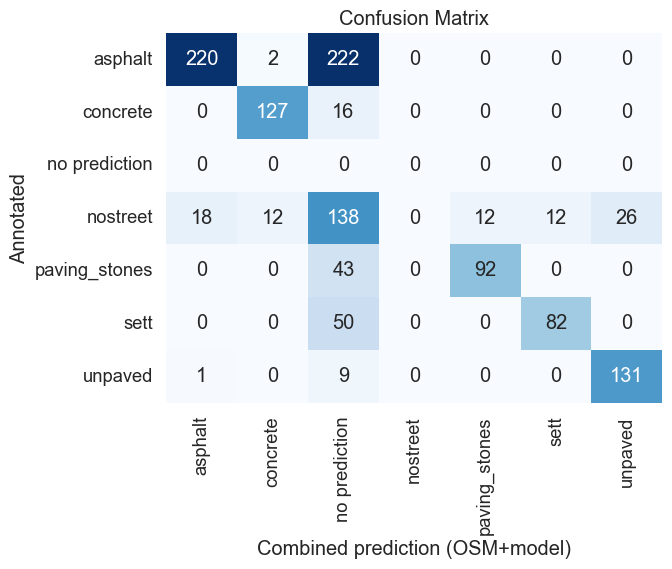

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true.values, y_pred.values)

# Plotting the confusion matrix using seaborn heatmap
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["asphalt", "concrete", "no prediction", "nostreet", "paving_stones", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "no prediction", "nostreet", "paving_stones", "sett", "unpaved"])
plt.title("Confusion Matrix")
plt.xlabel("Combined prediction (OSM+model)")
plt.ylabel("Annotated")
plt.show()

In [142]:
#df.to_csv("test.csv")
df["high_prob"] = False
df.loc[(df.class_probability > 0.85),"high_prob"] = True

In [143]:
df.groupby(["high_prob", "surface_annotated"]).size()

high_prob  surface_annotated
False      asphalt                4
           concrete               2
           nostreet               7
           paving_stones          1
           unpaved                4
True       asphalt              423
           concrete             134
           nostreet             164
           paving_stones        129
           sett                 132
           unpaved              136
dtype: int64

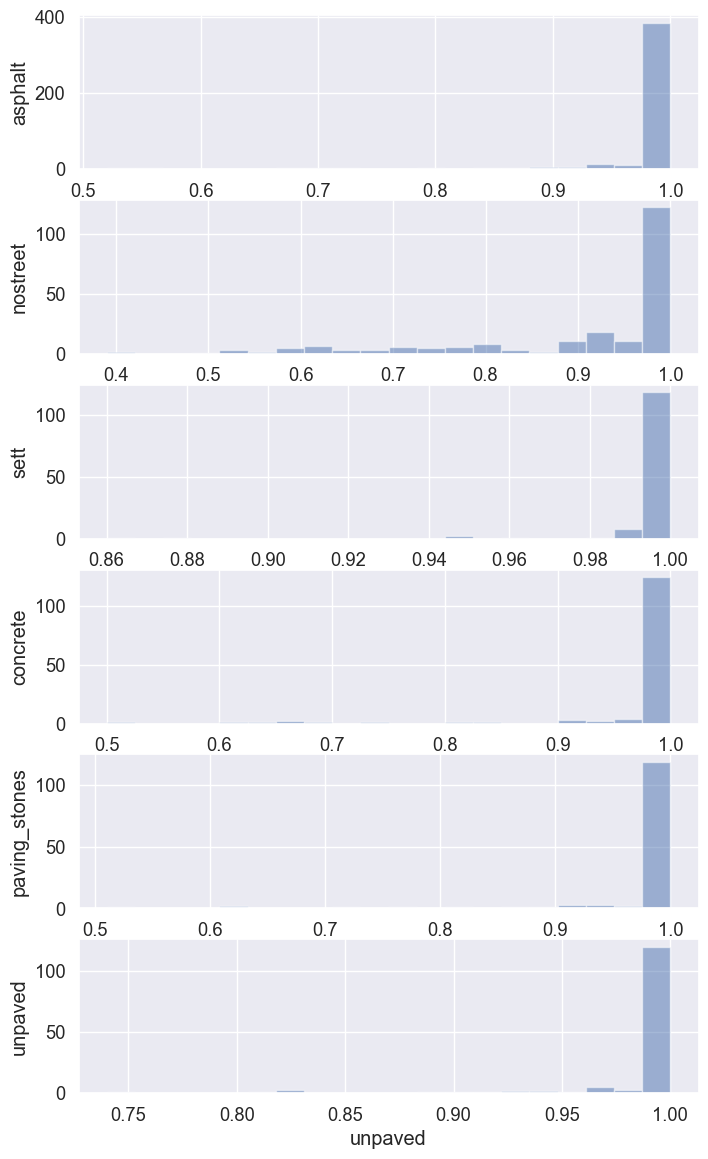

In [217]:
import matplotlib.pyplot as plt

# Create histograms for each class in the "surface" column as subplots
classes = df['surface_annotated'].unique()
num_classes = len(classes)

plt.figure(figsize=(8, 14))  # Set the figure size

for i, class_name in enumerate(classes, 1):
    class_data = df[df['surface_annotated'] == class_name]
    
    plt.subplot(num_classes, 1, i)
    plt.hist(class_data.class_probability, bins=20, alpha=0.5, label=class_name)
    
    plt.xlabel(f'{class_name}')
    plt.ylabel(f'{class_name}')

In [209]:
# where is no combined prediction?

df[df.combined_prediction == "no prediction"].shape[0]

478

In [210]:
counts_no_prediction = df[df.combined_prediction == "no prediction"].surface_annotated.value_counts(sort=False)
counts_no_prediction

asphalt          222
nostreet         138
sett              50
concrete          16
paving_stones     43
unpaved            9
Name: surface_annotated, dtype: int64

In [211]:
counts_all = df.surface_annotated.value_counts(sort=False)
counts_all

asphalt          444
nostreet         218
sett             132
concrete         143
paving_stones    135
unpaved          141
Name: surface_annotated, dtype: int64

In [212]:
counts_no_prediction / counts_all

asphalt          0.500000
nostreet         0.633028
sett             0.378788
concrete         0.111888
paving_stones    0.318519
unpaved          0.063830
Name: surface_annotated, dtype: float64

We mostly lose asphalt and those where we could not make a prediction.

In [214]:
smoothness_all = df.smoothness_annotated.value_counts(sort=False)
smoothness_all

excellent       189
good            395
bad             135
intermediate    263
very_bad         12
Name: smoothness_annotated, dtype: int64

In [215]:
smoothness_no_prediction = df[df.combined_prediction == "no prediction"].smoothness_annotated.value_counts(sort=False)

In [216]:
smoothness_no_prediction / smoothness_all

bad             0.303704
excellent       0.476190
good            0.397468
intermediate    0.193916
very_bad             NaN
Name: smoothness_annotated, dtype: float64